# Home 4: Build a CNN for image recognition.

### Name: Michael Eng


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [4]:
from tensorflow.keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [5]:
def to_one_hot(y, num_class=10):
    res = numpy.zeros((y.shape[0], num_class))
    for i,val in enumerate(y):
        res[i, val] = 1
    return res

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

NUM_CLASSES = 10

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [6]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [32]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Activation, Dropout, ZeroPadding2D, Add, LeakyReLU
from tensorflow.keras import utils, Input, initializers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, Model

def bn_relu(input):
    bn = BatchNormalization(axis=3)(input)
    return Activation('relu')(bn)

def residual_block(x, downsample: bool, filters: int, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size, strides=(1 if not downsample else 2), filters=filters, padding='same')(x)
    y = bn_relu(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding='same')(y)
    if downsample:
        x = Conv2D(kernel_size=kernel_size, strides=2, filters=filters, padding='same')(x)
    out = Add()([x,y])
    out = bn_relu(out)
    return out

def build_resnet(dropout = 0.0, num_blocks_list = [2,5,5,2]):
    num_filters = 64
    X_input = Input(shape=(32,32,3))
    X = ZeroPadding2D(padding=(3,3), data_format=None)(X_input)
    X = Conv2D(filters = num_filters, kernel_size=(7,7), strides=(1,1), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)
    # Stage 2 for ResNet

    for i,blocks in enumerate(num_blocks_list):
        for j in range(blocks):
            X = residual_block(X, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2

    x = AveragePooling2D(pool_size=(4,4), padding='same')(X)
    X = Flatten()(X)
    X = Dropout(dropout)(X)
    X = Dense(NUM_CLASSES, activation='softmax', name='fc' + str(NUM_CLASSES), kernel_initializer=glorot_uniform(seed=0))(X)
    name = 'ResNetDropOut' + str(int(dropout * 100))
    model = Model(inputs = X_input, outputs = X, name=name)
    return model


Learning rate 10^-5 no dropout, same convolutioins

In [16]:
from tensorflow.keras import optimizers

learning_rate = 1E-5 # to be tuned!

model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [17]:
history = model1.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 386s 307ms/step - loss: 2.2652 - acc: 0.2045 - val_loss: 1.8775 - val_acc: 0.3286
Epoch 2/10
1250/1250 [==============================] - 381s 305ms/step - loss: 1.7055 - acc: 0.3891 - val_loss: 1.7104 - val_acc: 0.3907
Epoch 3/10
1250/1250 [==============================] - 381s 305ms/step - loss: 1.4359 - acc: 0.4840 - val_loss: 1.6130 - val_acc: 0.4275
Epoch 4/10
1250/1250 [==============================] - 384s 307ms/step - loss: 1.2465 - acc: 0.5562 - val_loss: 1.5921 - val_acc: 0.4432
Epoch 5/10
1250/1250 [==============================] - 397s 317ms/step - loss: 1.0573 - acc: 0.6290 - val_loss: 1.6069 - val_acc: 0.4393
Epoch 6/10
1250/1250 [==============================] - 406s 325ms/step - loss: 0.9151 - acc: 0.6850 - val_loss: 1.6487 - val_acc: 0.4608
Epoch 7/10
1250/1250 [==============================] - 382s 306ms/step - loss: 0.7798 - acc: 0.7374 - val_loss: 1.6957 - val_acc: 0.4540
Epoch 8/10
1250/1250 [============

Learning rate 10^-4 no dropout, same convolutions

In [19]:
model2 = build_resnet()
model2.summary()

Model: "ResNetDropOut0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________

In [23]:
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history2 = model2.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 418s 332ms/step - loss: 1.9542 - acc: 0.3360 - val_loss: 1.3977 - val_acc: 0.5039
Epoch 2/10
1250/1250 [==============================] - 403s 322ms/step - loss: 1.1500 - acc: 0.5894 - val_loss: 1.3436 - val_acc: 0.5520
Epoch 3/10
1250/1250 [==============================] - 402s 322ms/step - loss: 0.8690 - acc: 0.6938 - val_loss: 1.4567 - val_acc: 0.5231
Epoch 4/10
1250/1250 [==============================] - 412s 330ms/step - loss: 0.6522 - acc: 0.7714 - val_loss: 1.3527 - val_acc: 0.5910
Epoch 5/10
1250/1250 [==============================] - 411s 329ms/step - loss: 0.4702 - acc: 0.8390 - val_loss: 1.3161 - val_acc: 0.6123
Epoch 6/10
1250/1250 [==============================] - 427s 342ms/step - loss: 0.3474 - acc: 0.8813 - val_loss: 1.3437 - val_acc: 0.6467
Epoch 7/10
1250/1250 [==============================] - 427s 342ms/step - loss: 0.2664 - acc: 0.9107 - val_loss: 1.1913 - val_acc: 0.6683
Epoch 8/10
1250/1250 [============

Learning rate 10^-3 no dropout same convolutions

In [21]:
model3 = build_resnet()
model3.summary()

Model: "ResNetDropOut0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 38, 38, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________

In [24]:
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 100),
              metrics=['acc'])
history3 = model3.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 421s 335ms/step - loss: 2.5958 - acc: 0.1303 - val_loss: 9.7224 - val_acc: 0.1114
Epoch 2/10
1250/1250 [==============================] - 411s 329ms/step - loss: 2.0030 - acc: 0.2344 - val_loss: 10.5875 - val_acc: 0.1604
Epoch 3/10
1250/1250 [==============================] - 388s 310ms/step - loss: 2.0408 - acc: 0.2338 - val_loss: 47.4849 - val_acc: 0.1672
Epoch 4/10
1250/1250 [==============================] - 388s 310ms/step - loss: 1.9013 - acc: 0.2690 - val_loss: 2.9498 - val_acc: 0.1987
Epoch 5/10
1250/1250 [==============================] - 390s 312ms/step - loss: 1.8471 - acc: 0.2935 - val_loss: 6.0383 - val_acc: 0.2178
Epoch 6/10
1250/1250 [==============================] - 405s 324ms/step - loss: 1.7885 - acc: 0.3022 - val_loss: 2.6981 - val_acc: 0.1773
Epoch 7/10
1250/1250 [==============================] - 401s 321ms/step - loss: 1.7378 - acc: 0.3256 - val_loss: 3.6083 - val_acc: 0.2145
Epoch 8/10
1250/1250 [==========

Learning rate 5 * 10^-5, reduced convolutions, no dropout

In [38]:
model4 = build_resnet()
model4.summary()

Model: "ResNetDropOut0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_25 (ZeroPadding2 (None, 38, 38, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_25[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________

In [39]:
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 5),
              metrics=['acc'])
history4 = model3.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 477s 382ms/step - loss: 1.0714 - acc: 0.6258 - val_loss: 1.1731 - val_acc: 0.6006
Epoch 2/10
1250/1250 [==============================] - 479s 383ms/step - loss: 1.0393 - acc: 0.6338 - val_loss: 1.1602 - val_acc: 0.6001
Epoch 3/10
1250/1250 [==============================] - 477s 381ms/step - loss: 0.9791 - acc: 0.6578 - val_loss: 1.1882 - val_acc: 0.5853
Epoch 4/10
1250/1250 [==============================] - 479s 383ms/step - loss: 0.9414 - acc: 0.6711 - val_loss: 1.0280 - val_acc: 0.6379
Epoch 5/10
1250/1250 [==============================] - 478s 383ms/step - loss: 0.9189 - acc: 0.6794 - val_loss: 1.8076 - val_acc: 0.6014
Epoch 6/10
1250/1250 [==============================] - 477s 382ms/step - loss: 0.8828 - acc: 0.6956 - val_loss: 1.7869 - val_acc: 0.5844
Epoch 7/10
1250/1250 [==============================] - 442s 354ms/step - loss: 0.8366 - acc: 0.7085 - val_loss: 0.9412 - val_acc: 0.6761
Epoch 8/10
1250/1250 [============

In [40]:
model5 = build_resnet(0.5)
model5.summary()

Model: "ResNetDropOut50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_26 (ZeroPadding2 (None, 38, 38, 3)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_26[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________

In [ ]:
model5.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history5a = model3.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 433s 346ms/step - loss: 0.7172 - acc: 0.7544 - val_loss: 1.1310 - val_acc: 0.6168
Epoch 2/10
1250/1250 [==============================] - 427s 342ms/step - loss: 0.7079 - acc: 0.7628 - val_loss: 3.0078 - val_acc: 0.6635
Epoch 3/10
1250/1250 [==============================] - 419s 335ms/step - loss: 0.6858 - acc: 0.7673 - val_loss: 3.0673 - val_acc: 0.6018
Epoch 4/10
1250/1250 [==============================] - 435s 348ms/step - loss: 0.6571 - acc: 0.7814 - val_loss: 3.9690 - val_acc: 0.6992
Epoch 5/10
1250/1250 [==============================] - 438s 351ms/step - loss: 0.6365 - acc: 0.7857 - val_loss: 0.9552 - val_acc: 0.7129
Epoch 6/10
1250/1250 [==============================] - 429s 343ms/step - loss: 0.6192 - acc: 0.7962 - val_loss: 1.4254 - val_acc: 0.6107
Epoch 7/10
1250/1250 [==============================] - 441s 353ms/step - loss: 0.5939 - acc: 0.8047 - val_loss: 1.0457 - val_acc: 0.7004
Epoch 8/10
1250/1250 [============

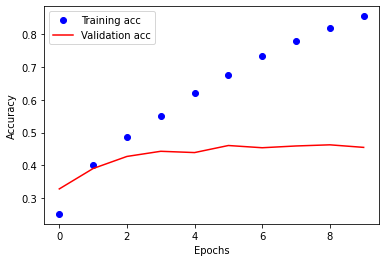

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [ ]:
<Compile your model again (using the same hyper-parameters)>
...

In [ ]:
<Train your model on the entire training set (50K samples)>
<Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
<Do NOT use the validation_data option (because now you do not have validation data)>
...

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [ ]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))